Import Necessary Libraries

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, accuracy_score
from kneed import KneeLocator

In [14]:
pip install kneed

Load the Dataset

In [4]:
# Load the dataset
df = pd.read_csv("/content/sbi_life_enhanced_anomaly_dataset.csv")  # Replace with actual file


Data Preprocessing

In [5]:
  # Drop unnecessary columns
  df = df.drop(columns=["Customer_ID"], errors="ignore")  # Remove if exists

  # Identify categorical and numerical columns
  categorical_cols = ["Income_Group", "Premium_Payment_Mode", "Agent_Involvement"]
  numerical_cols = ["Age", "Past_Experience", "Policy_Count", "Claim_History",
                    "Avg_Policy_Term", "Fraud_History", "Missed_Payments", "Premium_Amount"]

  # Handle missing values
  num_imputer = SimpleImputer(strategy="median")
  cat_imputer = SimpleImputer(strategy="most_frequent")

  df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])
  df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

  # Encode categorical variables
  for col in categorical_cols:
      df[col] = LabelEncoder().fit_transform(df[col])

Feature Engineering

In [27]:
# 1️⃣ Policy Lifetime: Longer duration = More stable customer
df["Policy_Lifetime"] = df["Avg_Policy_Term"] * df["Policy_Count"]

# 2️⃣ Claim Frequency: More claims per policy = Higher risk
df["Claim_Frequency"] = df["Claim_History"] / (df["Policy_Count"] + 1)  # Avoid division by zero

# 3️⃣ Missed Payment Rate: Higher means riskier
df["Missed_Payment_Rate"] = df["Missed_Payments"] / (df["Policy_Count"] + 1)

# 4️⃣ Income to Premium Ratio: Properly Mapping Income Group to Real Values
income_mapping = {"Low": 25000, "Medium": 75000, "High": 150000}  # Approximate income ranges
df["Income_Estimated"] = df["Income_Group"].map(income_mapping)
df["Income_to_Premium"] = df["Income_Estimated"] / (df["Premium_Amount"] + 1)

# 5️⃣ Fraud Impact: If they missed payments before & have fraud history = HIGH RISK
df["Fraud_Impact"] = df["Fraud_History"] * df["Missed_Payment_Rate"]

# 6️⃣ Agent Involvement Impact: If an agent is frequently changing policies = Red Flag
df["Agent_Involvement_Impact"] = df["Agent_Involvement"] * df["Policy_Count"]


In [24]:
df["Policy_Creation_Anomaly"] = np.where(
    (df["Policy_Count"] > df["Past_Experience"] * 2), 1, 0
)
df["Policy_Termination_Anomaly"] = np.where(
    (df["Claim_History"] > df["Policy_Count"] * 0.7) & (df["Avg_Policy_Term"] < 3), 1, 0
)
df["Policy_Termination_Anomaly"] = np.where(
    (df["Claim_History"] > df["Policy_Count"] * 0.7) & (df["Avg_Policy_Term"] < 3), 1, 0
)

Normalization using Standard Scaler

In [28]:
# Normalize all features (numerical + engineered)
scaler = StandardScaler()
all_features = numerical_cols + categorical_cols + [
    "Policy_Lifetime", "Claim_Frequency", "Missed_Payment_Rate",
    "Income_to_Premium", "Fraud_Impact", "Agent_Involvement_Impact",
    "Policy_Creation_Anomaly", "Policy_Termination_Anomaly", "Policy_Claim_Anomaly"
]
df[all_features] = scaler.fit_transform(df[all_features])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


NaN Check

In [31]:
# Ensure numerical features have no NaNs
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# Ensure categorical features have no NaNs
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# Re-check for NaNs after encoding
df = df.fillna(0)  # Fill any remaining NaNs with 0 as a fallback

# Verify all features are clean
assert df[all_features].isna().sum().sum() == 0, "There are still NaNs in the dataset!"


Finding Best Epsilon for DBSCAN using Elbow Method

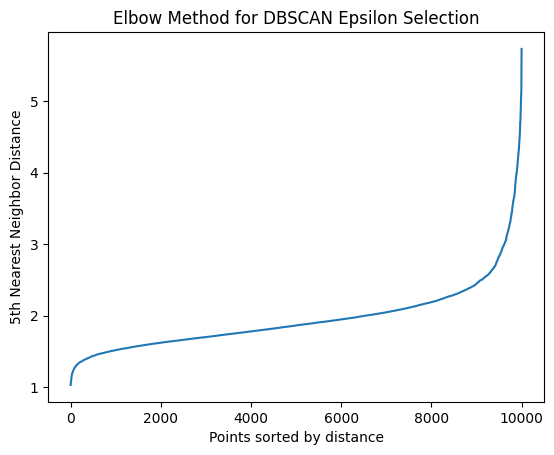

Best Epsilon Found: 2.4491051445215066


In [32]:

# Finding best epsilon using k-distance method

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df[all_features])
distances, indices = neighbors_fit.kneighbors(df[all_features])
distances = np.sort(distances[:, -1], axis=0)

# Plot k-distance graph
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("Elbow Method for DBSCAN Epsilon Selection")
plt.show()

# Set epsilon based on elbow method (adjust as needed)
best_epsilon = distances[int(len(distances) * 0.9)]  # Taking 90th percentile
print(f"Best Epsilon Found: {best_epsilon}")

Clustering using DBSCAN

In [171]:
# Apply DBSCAN for unsupervised anomaly detection
dbscan = DBSCAN(eps=2.44, min_samples=15)  # Adjust eps based on data
df["DBSCAN_Label"] = dbscan.fit_predict(df[all_features])


In [172]:
# Convert DBSCAN output to anomaly score (0: normal, 1: anomaly)
df["DBSCAN_Anomaly_Score"] = np.where(df["DBSCAN_Label"] != 0 , 1, 0)

Print Basic Summary

In [173]:
# Print Anomaly Detection Summary
total_anomalies = df["DBSCAN_Anomaly_Score"].sum()
total_customers = len(df)
anomaly_percentage = (total_anomalies / total_customers) * 100

print(f"Total Customers: {total_customers}")
print(f"Anomalies Detected: {total_anomalies}")
print(f"Anomaly Percentage: {anomaly_percentage:.2f}%")


# Count unique clusters
print("\nDBSCAN Cluster Distribution:")
print(df["DBSCAN_Label"].value_counts())


Total Customers: 10000
Anomalies Detected: 1584
Anomaly Percentage: 15.84%

DBSCAN Cluster Distribution:
DBSCAN_Label
 0    8416
-1    1368
 1     106
 2      49
 4      38
 3      23
Name: count, dtype: int64


In [193]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Compute distance to the nearest neighbor for ALL points (including noise)
nbrs = NearestNeighbors(n_neighbors=2).fit(df[all_features])  # n_neighbors=2 to exclude self-distance
distances, _ = nbrs.kneighbors(df[all_features])

# Normalize distances to [0,1] range (higher means more anomalous)
df["DBSCAN_Anomaly_Score"] = distances[:, 1]  # Use 2nd nearest neighbor distance
df["DBSCAN_Anomaly_Score"] = (df["DBSCAN_Anomaly_Score"] - df["DBSCAN_Anomaly_Score"].min()) / \
                             (df["DBSCAN_Anomaly_Score"].max() - df["DBSCAN_Anomaly_Score"].min())

print(df[["DBSCAN_Label", "DBSCAN_Anomaly_Score"]].head())


   DBSCAN_Label  DBSCAN_Anomaly_Score
0             0              0.189314
1             0              0.310447
2             0              0.059906
3             0              0.186925
4             0              0.259263
